# Enhanced Model Training Notebook with Model Selection

This notebook demonstrates an improved model training workflow that leverages multiple model types and the model selection functionality.

## Setup the environment

In [1]:
# Setup the environment
import time
import os
import sys
from pathlib import Path

# Ensure the src directory is in the path for imports
# Add the current directory to the path if not already there
current_dir = Path.cwd()
parent_dir = current_dir.parent if "notebooks" in str(current_dir) else current_dir
src_dir = parent_dir / "src"
if str(src_dir) not in sys.path:
    sys.path.append(str(src_dir))
    print(f"Added {src_dir} to path")

# Import dotenv if available
try:
    from dotenv import load_dotenv
    load_dotenv()
except ImportError:
    print("dotenv not installed, skipping...")

import logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s", datefmt='%H:%M:%S,')

# Check for environment variable
if "DSBA_MODELS_ROOT_PATH" not in os.environ:
    models_dir = parent_dir / "models"
    os.environ["DSBA_MODELS_ROOT_PATH"] = str(models_dir)
    os.makedirs(models_dir, exist_ok=True)
    logging.info(f"Set DSBA_MODELS_ROOT_PATH to {models_dir}")
else:
    logging.info(f"Using existing DSBA_MODELS_ROOT_PATH: {os.environ['DSBA_MODELS_ROOT_PATH']}")

23:42:35, [INFO] Set DSBA_MODELS_ROOT_PATH to c:\Users\fatin\Desktop\Oxford App\ESSEC\MLOPS\dsba-platform\src\models


Added c:\Users\fatin\Desktop\Oxford App\ESSEC\MLOPS\dsba-platform\src\src to path


## Data Loading and Preprocessing

In [2]:
# Data loading
from dsba.data_ingestion import load_csv_from_url

titanic_dataset_url = "https://raw.githubusercontent.com/datasciencedojo/datasets/refs/heads/master/titanic.csv"
titanic = load_csv_from_url(titanic_dataset_url)
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Problem setting
from dsba.preprocessing import split_dataframe, preprocess_dataframe, split_features_and_target

# Split into training and validation sets
titanic_train, titanic_val = split_dataframe(titanic, test_size=0.2)
target_column = "Survived"

# Preprocess data
titanic_train = preprocess_dataframe(titanic_train)
titanic_val = preprocess_dataframe(titanic_val)

# Extract features and target from training data
X_train, y_train = split_features_and_target(titanic_train, target_column)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {titanic_val.shape}")

Training set shape: (712, 11)
Validation set shape: (179, 12)


## Create Multiple Model Candidates

In [7]:
# Import required libraries
from dsba.model_selection import ModelCandidate, select_best_model, save_best_model, compare_models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# Create model candidates
logging.info("Creating model candidates...")
model_candidates = [
    ModelCandidate(
        model=LogisticRegression(max_iter=1000, random_state=42),
        name="Logistic Regression",
        hyperparameters={"max_iter": 1000, "random_state": 42}
    ),
    ModelCandidate(
        model=RandomForestClassifier(n_estimators=100, random_state=42),
        name="Random Forest",
        hyperparameters={"n_estimators": 100, "random_state": 42}
    ),
    ModelCandidate(
        model=GradientBoostingClassifier(n_estimators=100, random_state=42),
        name="Gradient Boosting",
        hyperparameters={"n_estimators": 100, "random_state": 42}
    ),
    ModelCandidate(
        model=xgb.XGBClassifier(random_state=42),
        name="XGBoost",
        hyperparameters={"random_state": 42}
    )
]

print(f"Created {len(model_candidates)} model candidates")

23:42:51, [INFO] Creating model candidates...


Created 4 model candidates


## Train All Models

In [9]:
# Train all models
for candidate in model_candidates:
    logging.info(f"Training {candidate.name}...")
    candidate.model.fit(X_train, y_train)

print("All models trained successfully")

23:42:56, [INFO] Training Logistic Regression...
c:\Users\fatin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
23:42:56, [INFO] Training Random Forest...
23:42:56, [INFO] Training Gradient Boosting...
23:42:56, [INFO] Training XGBoost...


All models trained successfully


## Compare Model Performance

In [10]:
# Compare all models
logging.info("Comparing models...")
comparison_df = compare_models(model_candidates, titanic_val, target_column)
comparison_df

23:43:01, [INFO] Comparing models...


,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.798883,0.797830,0.798883,0.797427
1,Random Forest,0.782123,0.783736,0.782123,0.782708
2,Gradient Boosting,0.754190,0.755293,0.754190,0.754647
3,XGBoost,0.770950,0.777714,0.770950,0.772387


## Visualize Model Comparison

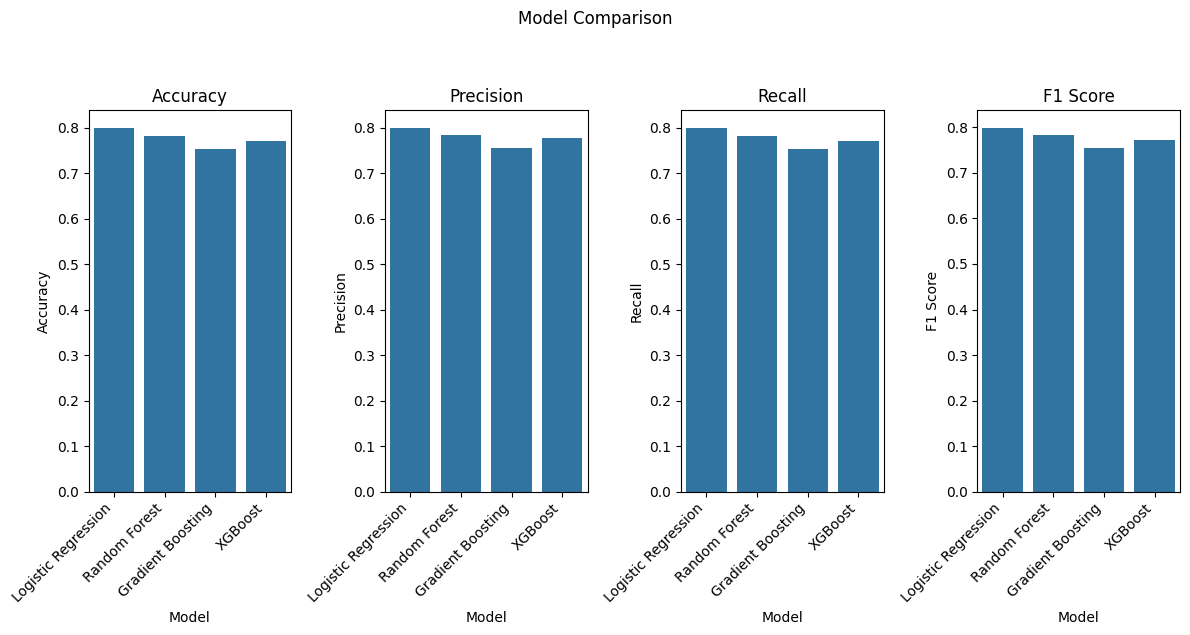

In [11]:
# Visualize model comparison
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Plot each metric
for i, metric in enumerate(metrics):
    plt.subplot(1, 4, i+1)
    sns.barplot(x='Model', y=metric, data=comparison_df)
    plt.xticks(rotation=45, ha='right')
    plt.title(metric)
    plt.tight_layout()

plt.suptitle('Model Comparison', y=1.05)
plt.tight_layout()
plt.show()

## Select the Best Model

In [12]:
# Select the best model based on F1 score
logging.info("Selecting the best model...")
best_model = select_best_model(
    model_candidates, 
    titanic_val, 
    target_column, 
    metric="f1_score"
)
logging.info(f"Best model: {best_model.name}")

# Display the best model's evaluation metrics
print(f"Best Model: {best_model.name}")
print(f"Accuracy: {best_model.evaluation_result.accuracy:.4f}")
print(f"Precision: {best_model.evaluation_result.precision:.4f}")
print(f"Recall: {best_model.evaluation_result.recall:.4f}")
print(f"F1 Score: {best_model.evaluation_result.f1_score:.4f}")

23:43:12, [INFO] Selecting the best model...
23:43:12, [INFO] Selected Logistic Regression as the best model based on f1_score
23:43:12, [INFO] Best model: Logistic Regression


Best Model: Logistic Regression
Accuracy: 0.7989
Precision: 0.7978
Recall: 0.7989
F1 Score: 0.7974


## Visualize Best Model's Confusion Matrix

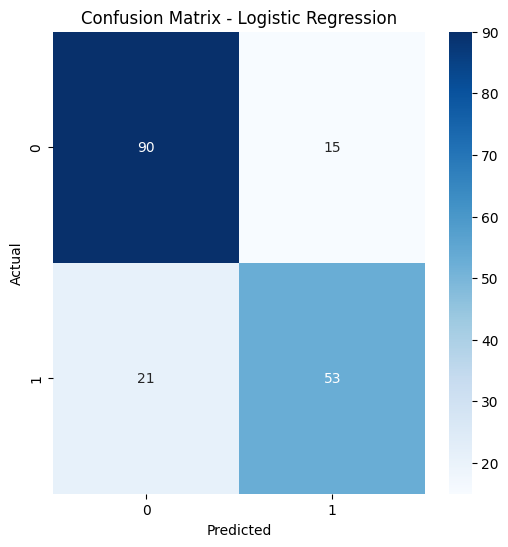

In [13]:
# Visualize the confusion matrix of the best model
from dsba.model_evaluation import plot_confusion_matrix
import matplotlib.pyplot as plt

confusion_matrix_fig = plot_confusion_matrix(best_model.evaluation_result)
plt.title(f"Confusion Matrix - {best_model.name}")
plt.show()

## Save the Best Model with Performance Metrics

In [ ]:
# Save the best model with performance metrics
from datetime import datetime
model_id = f"titanic_best_{datetime.now().strftime('%Y%m%d_%H%M')}" #save model name with time
logging.info(f"Saving the best model with ID: {model_id}...")
metadata = save_best_model(
    best_model,
    model_id=model_id,
    target_column=target_column,
    algorithm=best_model.name,
    description=f"Best model selected from multiple candidates on {datetime.now().strftime('%Y-%m-%d')}"
)

print("\nSaved Model Metadata:")
print(f"Model ID: {metadata.id}")
print(f"Algorithm: {metadata.algorithm}")
print(f"Created At: {metadata.created_at}")
print(f"Performance Metrics:")
for metric, value in metadata.performance_metrics.items():
    print(f"  {metric}: {value:.4f}")

23:43:45, [INFO] Saving the best model with ID: titanic_best_20250411_2343...
23:43:45, [INFO] Save model to path: C:\Users\fatin\Desktop\Oxford App\ESSEC\MLOPS\dsba-platform\src\models\titanic_best_20250411_2343.pkl
23:43:45, [INFO] Saved best model with ID: titanic_best_20250411_2343



Saved Model Metadata:
Model ID: titanic_best_20250411_2343
Algorithm: Logistic Regression
Created At: 2025-04-11 23:43:45.355663
Performance Metrics:
  accuracy: 0.7989
  precision: 0.7978
  recall: 0.7989
  f1_score: 0.7974


## Compare with Previously Saved Models if any exist

In [16]:
# List all models in the registry
from dsba.model_registry import list_models_ids, load_model_metadata

models = list_models_ids()
print(f"Models in registry: {len(models)}")

# Get metadata for all models
model_metrics = []
for model_id in models:
    try:
        metadata = load_model_metadata(model_id)
        metrics = {
            'model_id': model_id,
            'algorithm': metadata.algorithm,
            'created_at': metadata.created_at
        }
        
        # Add performance metrics if available
        if hasattr(metadata, 'performance_metrics') and metadata.performance_metrics:
            for metric, value in metadata.performance_metrics.items():
                metrics[metric] = value
                
        model_metrics.append(metrics)
    except Exception as e:
        print(f"Error loading metadata for {model_id}: {e}")

# Create a DataFrame with model information
models_df = pd.DataFrame(model_metrics)
if not models_df.empty:
    display(models_df.sort_values(by="f1_score", ascending=False) if "f1_score" in models_df.columns else models_df)
else:
    print("No models found in registry or models don't have performance metrics")

Models in registry: 1


,model_id,algorithm,created_at,accuracy,precision,recall,f1_score
0,titanic_best_20250411_2343,Logistic Regression,2025-04-11 23:43:45.355663,0.798883,0.79783,0.798883,0.797427
